# Toxic comment analysis using GRU

---


## Load libraries


In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

## Load Dataset


In [3]:
data = pd.read_csv("datasets/train.csv")
data.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

### Clean the data


In [4]:
print("Number of missing values in each column :")
print(data.isnull().sum())

Number of missing values in each column :
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


We will remove the rows with missing values and remove the id column as it is not relevant.


In [5]:
data = data.dropna()
del data["id"]

Our data is now clean and ready for analysis !


In [6]:
data.head()

comment_text  toxic  severe_toxic  \
0  Explanation\nWhy the edits made under my usern...      0             0   
1  D'aww! He matches this background colour I'm s...      0             0   
2  Hey man, I'm really not trying to edit war. It...      0             0   
3  "\nMore\nI can't make any real suggestions on ...      0             0   
4  You, sir, are my hero. Any chance you remember...      0             0   

   obscene  threat  insult  identity_hate  
0        0       0       0              0  
1        0       0       0              0  
2        0       0       0              0  
3        0       0       0              0  
4        0       0       0              0

In [7]:
from helpers.data.dataset import print_data_composition

print_data_composition(data)

Number of neutral comments : 143346

Number of toxic comments : 16225
| number of severe_toxic : 1595
| number of obscene : 8449
| number of threat : 478
| number of insult : 7877
| number of identity_hate : 1405


There is clearly imbalanced. The number of neutral comments is way greater than the number of toxic comments


## Rebalance the dataframe using downsampling

We remove neutral comments to balance the dataset


In [8]:
print_data_composition(data)


Number of neutral comments : 143346

Number of toxic comments : 16225
| number of severe_toxic : 1595
| number of obscene : 8449
| number of threat : 478
| number of insult : 7877
| number of identity_hate : 1405


In [9]:
# count the number of comments that have at least one label set to 1
toxic_comments = data[(data["toxic"] == 1) |
                      (data["severe_toxic"] == 1) |
                      (data["obscene"] == 1) |
                      (data["threat"] == 1) |
                      (data["insult"] == 1) |
                      (data["identity_hate"] == 1)]

toxic_comments


comment_text  toxic  \
6            COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK      1   
12      Hey... what is it..\n@ | talk .\nWhat is it......      1   
16      Bye! \n\nDon't look, come or think of comming ...      1   
42      You are gay or antisemmitian? \n\nArchangel WH...      1   
43               FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!      1   
...                                                   ...    ...   
159494  "\n\n our previous conversation \n\nyou fuckin...      1   
159514                  YOU ARE A MISCHIEVIOUS PUBIC HAIR      1   
159541  Your absurd edits \n\nYour absurd edits on gre...      1   
159546  "\n\nHey listen don't you ever!!!! Delete my e...      1   
159554  and i'm going to keep posting the stuff u dele...      1   

        severe_toxic  obscene  threat  insult  identity_hate  
6                  1        1       0       1              0  
12                 0        0       0       0              0  
16                 0        0       0       0              0  
42                 0        1       0       1              1  
43                 0        1       0       1              0  
...              ...      ...     ...     ...            ...  
159494             0        1       0       1              1  
159514             0        0       0       1              0  
159541             0        1       0       1              0  
159546             0        0       0       1              0  
159554             0        1       0       1              0  

[16225 rows x 7 columns]

### Downsample the data


In [10]:
num_toxic_comments = len(toxic_comments)
num_neutral_comments = len(data[(data["toxic"] == 0) &
                                (data["severe_toxic"] == 0) &
                                (data["obscene"] == 0) &
                                (data["threat"] == 0) &
                                (data["insult"] == 0) &
                                (data["identity_hate"] == 0)])

num_samples = min(num_toxic_comments, num_neutral_comments)

neutral_comments = data[(data["toxic"] == 0) &
                        (data["severe_toxic"] == 0) &
                        (data["obscene"] == 0) &
                        (data["threat"] == 0) &
                        (data["insult"] == 0) &
                        (data["identity_hate"] == 0)].sample(n=num_samples * 2)

data = pd.concat([toxic_comments, neutral_comments])

print_data_composition(data)

Number of neutral comments : 32450

Number of toxic comments : 16225
| number of severe_toxic : 1595
| number of obscene : 8449
| number of threat : 478
| number of insult : 7877
| number of identity_hate : 1405


### Clean the comments


In [11]:
data["comment_text"].head()

6          COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
12    Hey... what is it..\n@ | talk .\nWhat is it......
16    Bye! \n\nDon't look, come or think of comming ...
42    You are gay or antisemmitian? \n\nArchangel WH...
43             FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!
Name: comment_text, dtype: object

In [12]:
from helpers.data.process_comment import process_comment
from helpers.data.text_manipulation import TextManipulation

text_manipulator = TextManipulation()

comments = data["comment_text"].to_numpy()

labels_columns = [
    "toxic",
    "severe_toxic",
    "obscene",
    "threat",
    "insult",
    "identity_hate",
]
labels = data[labels_columns].to_numpy()

for i, comment in enumerate(comments):
    comments[i] = process_comment(comment)



[nltk_data] Downloading package stopwords to /home/loulou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/loulou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/loulou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/loulou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/loulou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/loulou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/loulou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/loulou/nltk_data...
[nltk_data]   Package stopwords is already up-t

### Tokenize the comments


In [13]:
MAX_TOKENS = 1500

In [14]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_TOKENS, oov_token="<OOV>")
tokenizer.fit_on_texts(comments)

vocab_size = len(tokenizer.word_index) + 1

2024-03-15 10:30:24.959732: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 10:30:24.959801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 10:30:25.007846: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-15 10:30:25.116384: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 10:30:26.361020: W tensorflow/compiler/tf2

In [15]:
sequences = tokenizer.texts_to_sequences(comments)
print(sequences[:5])
comments = pad_sequences(sequences, padding="post", maxlen=MAX_TOKENS)

[[596, 150, 3, 1, 292, 17, 25, 143], [260, 36, 8, 12, 53, 36, 8, 12, 30, 1, 441, 9, 62, 681, 1, 14, 99, 41, 1, 1, 1, 56, 1, 69, 60, 55, 56, 1, 88, 291, 40, 94, 1, 7, 1, 1, 41, 681, 229, 1, 4, 1, 69, 71, 787, 92, 315, 32, 1, 1084], [1, 21, 11, 159, 221, 27, 72, 9, 1, 156, 1], [3, 14, 148, 27, 1, 1, 610, 1, 1, 1, 1, 46, 14, 178, 1196, 75, 3, 21, 1, 25, 211, 40, 1, 10, 1, 26, 1, 1, 9, 447, 7, 11, 1, 308, 24, 3, 14, 1, 92, 1, 20, 676, 1, 7, 84, 4, 2, 1, 1, 276, 24, 3, 796, 406, 9, 2, 1, 10, 1, 8, 6, 1, 1, 96, 6, 1, 1, 17, 20, 1, 84, 4, 2, 1, 1, 23, 20, 148, 1, 340, 126, 7, 263, 407, 3, 105, 148, 5, 33, 11, 689, 24, 60, 63, 798, 1, 45, 322, 13, 25, 34, 5, 21, 11, 518, 4, 53, 4, 3, 1012, 1, 9, 2, 1, 661], [47, 20, 1, 560, 13, 2, 122, 1]]


In [16]:
comments[:5, :10]

array([[596, 150,   3,   1, 292,  17,  25, 143,   0,   0],
       [260,  36,   8,  12,  53,  36,   8,  12,  30,   1],
       [  1,  21,  11, 159, 221,  27,  72,   9,   1, 156],
       [  3,  14, 148,  27,   1,   1, 610,   1,   1,   1],
       [ 47,  20,   1, 560,  13,   2, 122,   1,   0,   0]], dtype=int32)

In [17]:
comments.shape

(48675, 1500)

## Analyse the text


### Split the training and test data


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(comments, labels, test_size=0.2, random_state=42)

In [19]:
print(f"Train data samples : {len(X_train)}")
print(f"Test data samples : {len(X_test)}")

Train data samples : 38940
Test data samples : 9735


In [20]:
MODEL_PATH = "models/GRU"

In [21]:
import os

os.makedirs(MODEL_PATH, exist_ok=True)

In [22]:
import joblib

with open(f"{MODEL_PATH}/vectorizer.pkl", "wb") as f:
    joblib.dump(tokenizer, f)

## Callbacks


## Build the model

### Load GloVe embeddings


In [23]:
EMBEDDING_DIM = 100
GLOVE_PATH = 'GloVe/glove.6B.100d.txt'

In [24]:
embeddings_index = {}
with open(GLOVE_PATH) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i < MAX_TOKENS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### CSV Logger


In [25]:
from tensorflow.keras.callbacks import CSVLogger

csv_callback = CSVLogger(
    f"{MODEL_PATH}/metrics.csv"
)

### Model checkpoint


In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint_callback = ModelCheckpoint(
    filepath=f"{MODEL_PATH}/model.keras",
    monitor='val_loss',
    mode='min',
    save_best_only=True)

## Model Architecture


In [27]:
DROPOUT = 0.2

In [28]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Bidirectional, GlobalMaxPool1D, GRU, Embedding, BatchNormalization, Dropout
from tensorflow.keras.initializers import Constant

number_of_classes = len(labels_columns)

model = Sequential()

model.add(Input(shape=(MAX_TOKENS,)))
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM,
                    embeddings_initializer=Constant(embedding_matrix), trainable=False))
#
model.add(Bidirectional(GRU(EMBEDDING_DIM, return_sequences=True)))
model.add(Dropout(DROPOUT))
#
model.add(GlobalMaxPool1D())
#
model.add(Dense(EMBEDDING_DIM, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(DROPOUT))
#
model.add(Dense(number_of_classes, activation="sigmoid"))

model.compile(optimizer="adam", metrics=["accuracy"], loss="binary_crossentropy")
model.summary()

2024-03-15 10:30:37.481327: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-15 10:30:37.672390: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-15 10:30:37.672458: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-15 10:30:37.677261: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-15 10:30:37.677332: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 100)         10891600  
                                                                 
 bidirectional (Bidirection  (None, 1500, 200)         121200    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1500, 200)         0         
                                                                 
 global_max_pooling1d (Glob  (None, 200)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 batch_normalization (Batch  (None, 100)               4

## Model training


In [29]:
NUM_EPOCHS = 6
BATCH_SIZE = 32

In [30]:
history = model.fit(
    X_train,
    y_train,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[model_checkpoint_callback, csv_callback],
)

Epoch 1/6


2024-03-15 10:30:42.879235: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-15 10:30:44.405508: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f45443f3fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-15 10:30:44.405560: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-03-15 10:30:44.422430: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710495044.530706   15773 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


974/974 [==============================] - 299s 301ms/step - loss: 0.2115 - accuracy: 0.7296 - val_loss: 0.1598 - val_accuracy: 0.9787
Epoch 2/6
974/974 [==============================] - 294s 302ms/step - loss: 0.1497 - accuracy: 0.8764 - val_loss: 0.1511 - val_accuracy: 0.9795
Epoch 3/6
974/974 [==============================] - 297s 305ms/step - loss: 0.1434 - accuracy: 0.8831 - val_loss: 0.1471 - val_accuracy: 0.9515
Epoch 4/6
974/974 [==============================] - 247s 253ms/step - loss: 0.1395 - accuracy: 0.8437 - val_loss: 0.1471 - val_accuracy: 0.8920
Epoch 5/6
974/974 [==============================] - 252s 259ms/step - loss: 0.1352 - accuracy: 0.8334 - val_loss: 0.1555 - val_accuracy: 0.9552
Epoch 6/6
974/974 [==============================] - 292s 299ms/step - loss: 0.1319 - accuracy: 0.8120 - val_loss: 0.1358 - val_accuracy: 0.8594


## Evaluate the model


### Show the training history


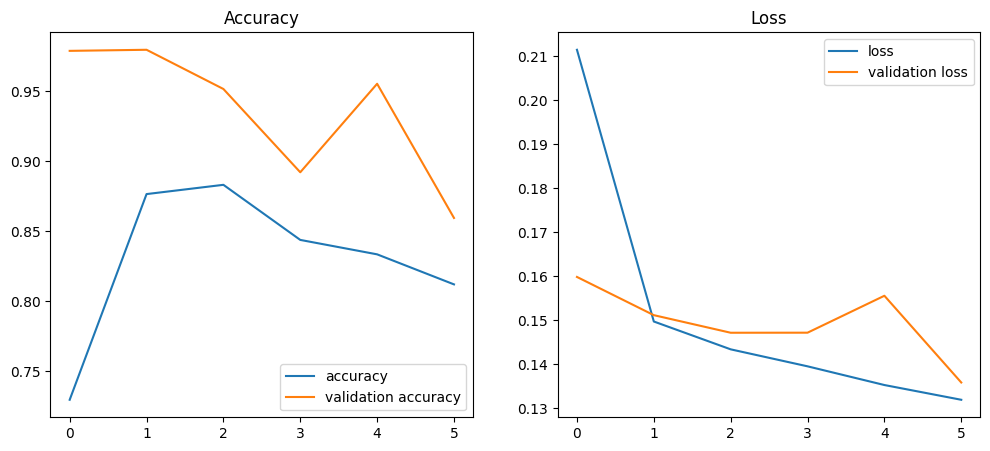

In [31]:
from helpers.data.show_training_metrincs import show_training_metrics

show_training_metrics(f"{MODEL_PATH}/metrics.csv")

### Evaluate the model on the test data


In [32]:
evaluation = model.evaluate(X_test, y_test)
print(evaluation)

305/305 [==============================] - 34s 110ms/step - loss: 0.1347 - accuracy: 0.8591
[0.13469445705413818, 0.8590652346611023]


In [33]:
sentence = ["I love you so much, you are the best person in the world"]

sentence = process_comment(sentence[0])
print(sentence)

sentence = tokenizer.texts_to_sequences([sentence])
print(sentence)
sentence = pad_sequences(sentence, padding="post", maxlen=MAX_TOKENS)

print(sentence)

prediction = model.predict(sentence)
print(labels_columns)
print(prediction)


i love you so much you are the best person in the world
[[5, 328, 3, 38, 138, 3, 14, 2, 243, 200, 13, 2, 251]]
[[  5 328   3 ...   0   0   0]]


[nltk_data] Downloading package stopwords to /home/loulou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1/1 [==============================] - 1s 742ms/step
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
[[0.13776897 0.00405617 0.03873812 0.00092376 0.0405382  0.00430241]]
